# Practica Analisis de Grafos

## Importacion de librerias

In [1]:
#Librerias Spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

#Resto de librerias
import ast
from typing import List
from os import listdir
from time import sleep
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph
import networkx as nx
from networkx.algorithms import community
from netgraph import Graph
import spacy
from collections import Counter

##  Importacion Musica Historica

In [2]:
def get_streamings(path: str = 'MyData') -> List[dict]:

    files = ['MyData/' + x for x in listdir(path)
             if x.split('.')[0][:-1] == 'StreamingHistory']

    all_streamings = []

    for file in files:
        with open(file, 'r', encoding='UTF-8') as f:
            new_streamings = ast.literal_eval(f.read())
            all_streamings += [streaming for streaming
                               in new_streamings]
    return all_streamings

In [3]:
streamings = get_streamings()
print(f'Recovered {len(streamings)} streamings.')

Recovered 2689 streamings.


## Creaccion de Conexion con API

In [4]:
with open("secreto.txt", "r") as f:
    client_id = f.readline().strip()
    client_secret = f.readline().strip()
    username = f.readline().strip()
    redirect_uri = f.readline().strip()

scope = 'user-read-recently-played'

In [5]:
#creamos las variables de cliente y cliente secreto
print(  "client_id: " + client_id + "\n" +
        "client_secret: " + client_secret + "\n"
        "username: " + username + "\n"
        "redirect_uri: " + redirect_uri + "\n"
        )

client_id: fa1ebaefdf2d41428ca9a296abb6c02c
client_secret: 9cffa430a6a042549a03cdb832d77c18
username: sposti_dani
redirect_uri: http://localhost/



In [6]:
def get_token(user: str,
              client_id: str,
              client_secret: str,
              redirect_uri: str,
              scope: str) -> str:

    token = util.prompt_for_user_token(user,scope,
                                               client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri)
    return token

In [7]:
#recover streamings history
token = get_token(username, client_id,
                    client_secret, redirect_uri, scope)
token

'BQBa6yK_xn5KtjN2ifv2JiA3NQim_MJx4R8W9xb7mvoPaSSVZ1kP5oHEwmMsodm6N6x475GKeTppaNVjhCNGn34zKU4x6TYug3o8kUW90ovFmezkuczu3zZll3CaOh4wnknbhaR2qA6b6YCTiSfB0EjX2k8dBJROvr_Xsnz4P6CfV6XYvl3BY71VSqDcaAak'

In [8]:
streamings = get_streamings()
print(f'Recovered {len(streamings)} streamings.')

Recovered 2689 streamings.


In [9]:
#getting a list of unique tracks in our history
# Add artist names too as multiple artist can have same song name
tracks = set([f"{streaming['trackName']}___{streaming['artistName']}" for streaming in streamings])
print(f'Discovered {len(tracks)} unique tracks.')

Discovered 607 unique tracks.


In [10]:
def get_saved_ids(tracks, path: str = 'output/track_ids.csv') -> dict:
    track_ids = {track: None for track in tracks}
    folder, filename = path.split('/')
    if filename in listdir(folder):
        try:
            idd_dataframe = pd.read_csv('output/track_ids.csv',
                                     names = ['name', 'idd'])
            idd_dataframe = idd_dataframe[1:]                    #removing first row
            added_tracks = 0
            for index, row in idd_dataframe.iterrows():
                if not row[1] == 'nan':                          #if the id is not nan
                    track_ids[row[0]] = row[1]                    #add the id to the dict
                    added_tracks += 1
            print(f'Saved IDs successfully recovered for {added_tracks} tracks.')
        except:
            print('Error. Failed to recover saved IDs!')
            pass
    return track_ids

In [11]:
#getting saved ids for tracks
track_ids = get_saved_ids(tracks)

Saved IDs successfully recovered for 607 tracks.


In [12]:
#checking tracks that still miss idd
tracks_missing_idd = len([track for track in tracks if track_ids.get(track) is None])
print(f'There are {tracks_missing_idd} tracks missing ID.')

There are 0 tracks missing ID.


In [13]:
def get_api_id(track_info: str, token: str) -> str:

    '''Performs a query on Spotify API to get a track ID.
    See https://curl.trillworks.com/'''

    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }
    track_name = track_info.split("___")[0]
    params = [
    ('q', track_name),
    ('type', 'track'),
    ]
    artist = track_info.split("___")[-1]
    if artist:
        params.append(('artist', artist))

    try:
        response = requests.get('https://api.spotify.com/v1/search',
                    headers = headers, params = params, timeout = 5)
        json = response.json()
        results = json['tracks']['items']
        first_result = json['tracks']['items'][0]
        # Check if searched artist is in response as the first one isn't
        # necessarily the right one
        if artist:
            for result in results:
                if artist.strip() == result['artists'][0]['name'].strip():
                    track_id = result['id']
                    return track_id
        # If specific artist is not found from results, use the first one
        track_id = first_result['id']
        return track_id
    except:
        return None

In [14]:
if tracks_missing_idd > 0:
    #using spotify API to recover track ids
    #note: this methods works only for tracks.
    #podcasts and other items will be ignored.
    print('Connecting to Spotify to recover tracks IDs.')
    sleep(3)
    id_length = 22
    for track, idd in track_ids.items():
        if idd is None:
            try:
                found_idd = get_api_id(track, token)
                track_ids[track] = found_idd
                print(f"{found_idd:<{id_length}} : {', '.join(track.split('___'))}")
            except:
                pass

    #how many tracks did we identify?
    identified_tracks = [track for track in track_ids
                        if track_ids[track] is not None]
    print(f'Successfully recovered the ID of {len(identified_tracks)} tracks.')

    #how many items did we fail to identify?
    n_tracks_without_id = len(track_ids) - len(identified_tracks)
    print(f"Failed to identify {n_tracks_without_id} items. "
            "However, some of these may not be tracks (e.g. podcasts).")

    #using pandas to save tracks ids (so we don't have to API them in the future)
    ids_path = 'output/track_ids.csv'
    ids_dataframe = pd.DataFrame.from_dict(track_ids,
                                               orient = 'index')
    ids_dataframe.to_csv(ids_path)
    print(f'track ids saved to {ids_path}.')

In [15]:
def get_saved_features(tracks, path = 'output/features.csv'):
    folder, file = path.split('/')
    track_features = {track: None for track in tracks}
    if file in listdir(folder):
        features_df = pd.read_csv(path, index_col = 0)
        n_recovered_tracks = 0
        for track in features_df.index:
            features = features_df.loc[track, :]
            if not features.isna().sum():          #if all the features are there
                track_features[track] = dict(features)
                n_recovered_tracks += 1
        print(f"Added features for {n_recovered_tracks} tracks.")
        return track_features
    else:
        print("Did not find features file.")
        return track_features

In [16]:
#recovering saved features
track_features = get_saved_features(tracks)
tracks_without_features = [track for track in tracks if track_features.get(track) is None]
print(f"There are still {len(tracks_without_features)} tracks without features.")
path = 'output/features.csv'

Added features for 607 tracks.
There are still 0 tracks without features.


In [17]:
def get_album(track_id: str, token: str) -> dict:
    sp = spotipy.Spotify(auth=token)
    try:
        album = sp.track(track_id)
        album_id = album['album']['id']
        album_name = album['album']['name']
        return album_name, album_id
    except:
        return None

In [18]:
def get_api_features(track_id: str, token: str) -> dict:
    sp = spotipy.Spotify(auth=token)
    try:
        features = sp.audio_features([track_id])
        return features[0]
    except:
        return None

In [19]:
#connecting to spotify API to retrieve missing features
if len (tracks_without_features):
    print('Connecting to Spotify to extract features...')
    acquired = 0
    for track, idd in track_ids.items():
        if idd is not None and track in tracks_without_features:
            try:
                features = get_api_features(idd, token)
                track_features[track] = features
                features['albumName'], features['albumID'] = get_album(idd, token)
                if features:
                    acquired += 1
                    print(f"Acquired features: {', '.join(track.split('___'))}. Total: {acquired}")
            except:
                features = None
    tracks_without_features = [track for track in tracks if track_features.get(track) is None]
    print(f'Successfully recovered features of {acquired} tracks.')
    if len(tracks_without_features):
        print(f'Failed to identify {len(tracks_without_features)} items. Some of these may not be tracks.')

In [20]:
#saving features
features_dataframe = pd.DataFrame(track_features).T
features_dataframe.to_csv(path)
print(f'Saved features to {path}.')

Saved features to output/features.csv.


In [21]:
#joining features and streamings
print('Adding features to streamings...')
streamings_with_features = []
for streaming in sorted(streamings, key= lambda x: x['endTime']):
    track = streaming['trackName'] + "___" + streaming['artistName']
    features = track_features.get(track)
    if features:
        streamings_with_features.append({'name': track, **streaming, **features})
print(f'Added features to {len(streamings_with_features)} streamings.')
print('Saving streamings...')
df_final = pd.DataFrame(streamings_with_features)
perc_featured = round(len(streamings_with_features) / len(streamings) *100, 2)
print(f"Done! Percentage of streamings with features: {perc_featured}%.")
print("Run the script again to try getting more information from Spotify.")

Adding features to streamings...
Added features to 2689 streamings.
Saving streamings...
Done! Percentage of streamings with features: 100.0%.
Run the script again to try getting more information from Spotify.


In [22]:
#añadimos el tipo track a las canciones
df_final["type"]="track"

Sacamos un dataframe de los artistas

In [23]:
#Autentificacion
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

#creo el objeto que utilizara las credenciales para interactuar con la API
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [24]:
# Add artist names too as multiple artist can have same song name
artistas = list(set([artista for artista in df_final['artistName']]))
print(f'Discovered {len(artistas)} unique artists.')

Discovered 270 unique artists.


In [25]:
def get_artist_info(artist_name):
    result = sp.search(q=f"artist:{artist_name}", type="artist", limit=1)


    if not result['artists']['items']:
        return {
            'name': '',
            'followers': None,
            'genres': [],
            'id': '',
            'image1': None,
            'image2': None,
            'image3': None,
            'popularity': None,
            'type': '',
            'uri': ''
        }

    artist = result['artists']['items'][0]

    return {
        'name': artist['name'],
        'followers': artist['followers']['total'],
        'genres': list(artist['genres']) if isinstance(artist['genres'], (list, tuple)) else [],
        'id': artist['id'],
        'image1': artist['images'][0]['url'] if len(artist['images']) > 0 else None,
        'image2': artist['images'][1]['url'] if len(artist['images']) > 1 else None,
        'image3': artist['images'][2]['url'] if len(artist['images']) > 2 else None,
        'popularity': artist['popularity'],
        'type': artist['type'],
        'uri': artist['uri']
    }

In [26]:
def fetch_artists_info_in_batches(artists, batch_size):

    for i in range(0, len(artists), batch_size):
        batch_artists = artists[i:i + batch_size]
        artist_info_list = [get_artist_info(artist) for artist in batch_artists]
        if i==0:
            df_artistas = pd.DataFrame(artist_info_list)
        df_lista_artistas = pd.DataFrame(artist_info_list)
        df_artistas = pd.concat([df_artistas, df_lista_artistas], ignore_index=True)

    return df_artistas

In [27]:
# Set batch size
batch_size = 10
# Fetch artist info in batches and create a DataFrame
df_artistas = fetch_artists_info_in_batches(artistas, batch_size)
artist_path = 'output/artists_ids.csv'
df_artistas.to_csv(artist_path)

In [28]:
len(df_artistas)

280

Sacamos un dataframe de los albumes

In [29]:
Albums=df_final[["albumName","albumID"]]
album_ids=list(set(list(df_final["albumID"])))

In [30]:
def get_album_info(album_id):
    try:
        album = sp.album(album_id)
    except:
        return {
            'name': '',
            'type': '',
            'id': '',
            'uri': '',
            'image1': None,
            'image2': None,
            'image3': None,
            'artist_id': '',
            'release_date': '',
            'release_date_precision': '',
            'popularity': None,
            'total_tracks': None,
            'genres': []
        }

    return {
        'name': album['name'],
        'type': album['type'],
        'id': album['id'],
        'uri': album['uri'],
        'image1': album['images'][0]['url'] if len(album['images']) > 0 else None,
        'image2': album['images'][1]['url'] if len(album['images']) > 1 else None,
        'image3': album['images'][2]['url'] if len(album['images']) > 2 else None,
        'artist_id': album['artists'][0]['id'] if len(album['artists']) > 0 else '',
        'release_date': album['release_date'],
        'release_date_precision': album['release_date_precision'],
        'popularity': album['popularity'],
        'total_tracks': album['total_tracks']
    }

In [31]:
album_info_list = [get_album_info(album_id) for album_id in album_ids]
df_albums = pd.DataFrame(album_info_list)

In [32]:
#antes de guardarlo creamos la variable 'release_year' y eliminamos 'release_date' y 'release_date_precision'
df_albums['release_year'] = pd.to_numeric(df_albums['release_date'].str.slice(0, 4), errors='coerce')
df_albums['release_year'] = df_albums['release_year'].fillna(0).astype(int)
df_albums=df_albums.drop(columns=['release_date','release_date_precision'])

In [33]:
print(len(df_albums))
album_path = 'output/album_ids.csv'
df_albums.to_csv(album_path)

478


Sacamos el numero de veces que se ha escuchado una cancion y le asociamos sus atributos

In [34]:
agg_df = df_final.groupby('uri').agg(
    n_times_listen=('uri', 'count'),
    n_min_played=('msPlayed', lambda x: x.sum() * 0.0000166667)
).reset_index()

In [35]:
len(agg_df)

594

In [36]:
df_tracks_ids_final = (
    pd.merge(agg_df, df_final.drop(columns=['msPlayed','name','endTime']), on='uri', how='left')
    .drop_duplicates(subset=['uri'])
    .sort_values(by='n_times_listen', ascending=False)
    )

In [37]:
track_final_path = 'output/tracks_ids_final.csv'
df_tracks_ids_final.to_csv(track_final_path)

Por ultimo sacamos una lista de los generos diferentes escuchados

In [38]:
exploded_df = df_artistas.explode('genres')
df_genres = exploded_df['genres'].unique()
df_genres = pd.DataFrame(df_genres, columns=['genres'])

In [39]:
print(len(df_genres))
genre_path = 'output/genres_ids.csv'
df_genres.to_csv(genre_path)

320


## Inclusion nodos y aristas en el grafo

In [40]:
#parametros del grafo
factor_spring_layout=0.7

In [41]:
#creamos el grafo vacio
G = nx.Graph()

In [42]:
#generamos una funcion para visualizar el grafo con los cambios que vamos haciendo
def visualizacion_grafo(G,factor_spring_layout):

    components = list(nx.connected_components(G))

    # Creamos un nuevo grafo que coja el subgrafo conectado mas grande
    #largest_component = max(components, key=len)
    #G = G.subgraph(largest_component)
    degrees = dict(nx.degree(G))
    colors = [degrees[node] for node in G.nodes()]

    #pintamos el grafo poniendo colores segun el grado y extendiendolo los nodos mas alejados
    plt.figure(figsize=(14, 9))
    pos = nx.spring_layout(G, k=factor_spring_layout)
    nx.draw(G, pos, with_labels=True, node_size=1200, alpha=0.8, node_color=colors, cmap=plt.get_cmap('coolwarm'))
    plt.show()

In [43]:
#incluimos los nodos de genero musical
for index, row in df_genres.iterrows():
    genre = row['genres']
    G.add_node(genre,
               id=genre,
               type='genre')

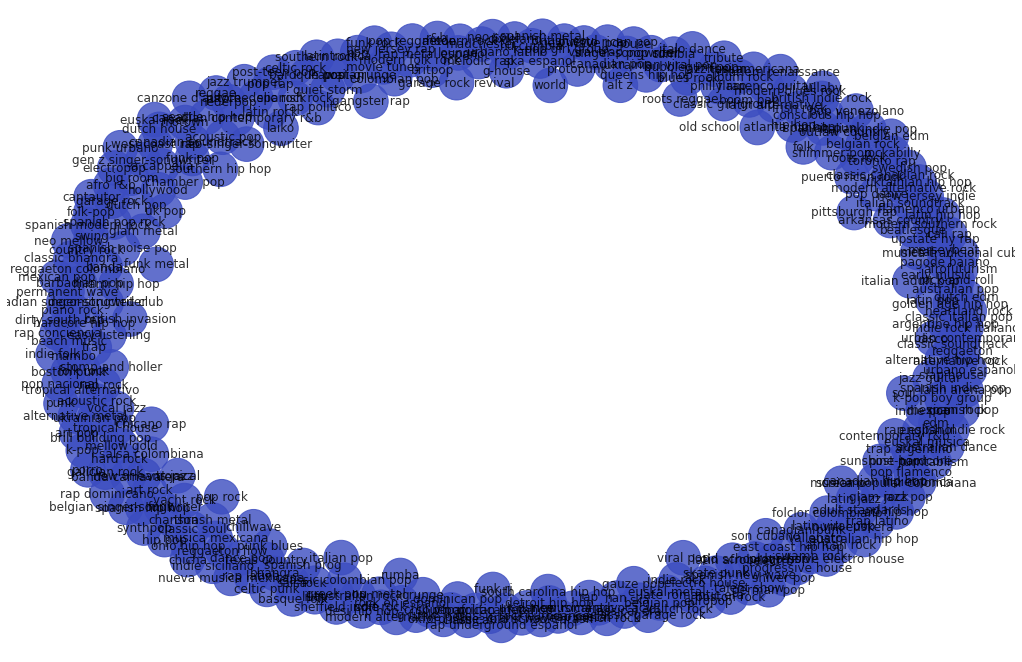

In [45]:
visualizacion_grafo(G,factor_spring_layout)

In [44]:
#ahora incluimos los nodos de los artistas con sus aristas con los generos
for index, row in df_artistas.iterrows():
    artist_name = row['name']

    G.add_node(artist_name,
               image=row['image3'],
               id=row['name'],
               type=row['type'],
               followers=row['followers'],
               popularity=row['popularity'],
               uri=row['uri'])

    # ahora creamos las aristas con los generos
    for genre in row['genres']:
        if genre in G.nodes:
            G.add_edge(artist_name, genre)

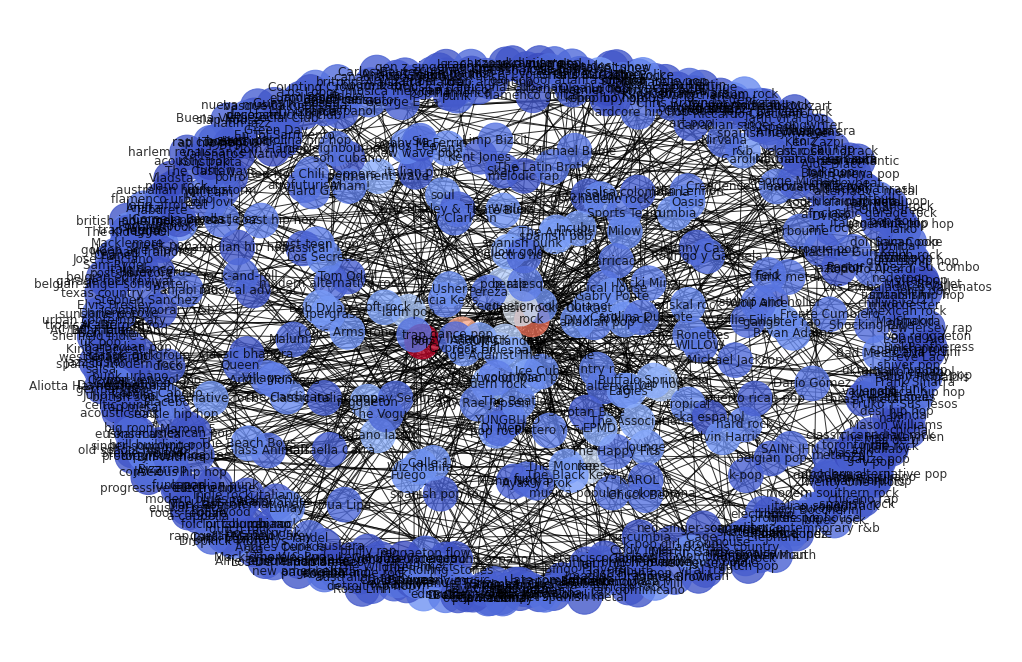

In [48]:
visualizacion_grafo(G,factor_spring_layout)

In [45]:
#ahora incluimos los nodos de sus albums con sus aristas con los artistas
for index, row in df_albums.iterrows():
    album_name = row['name']
    artist_id = row['artist_id']

    G.add_node(album_name,
               image=row['image3'],
               type=row['type'],
               popularity=row['popularity'],
               total_tracks=row['total_tracks'],
               release_year=row['release_year'],
               id=row['id'],
               uri=row['uri'])

    # vemos si hay algun nodo de artista que tenga ese id
    artist_node = None
    for node, attr in G.nodes(data=True):
        if 'id' in attr and attr['type'] == 'artist' and attr['id'] == artist_id:
            artist_node = node
            break

    # si existe entonces creamos la arista
    if artist_node is not None:
        G.add_edge(album_name, artist_node)

C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12435 (\N{HIRAGANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3

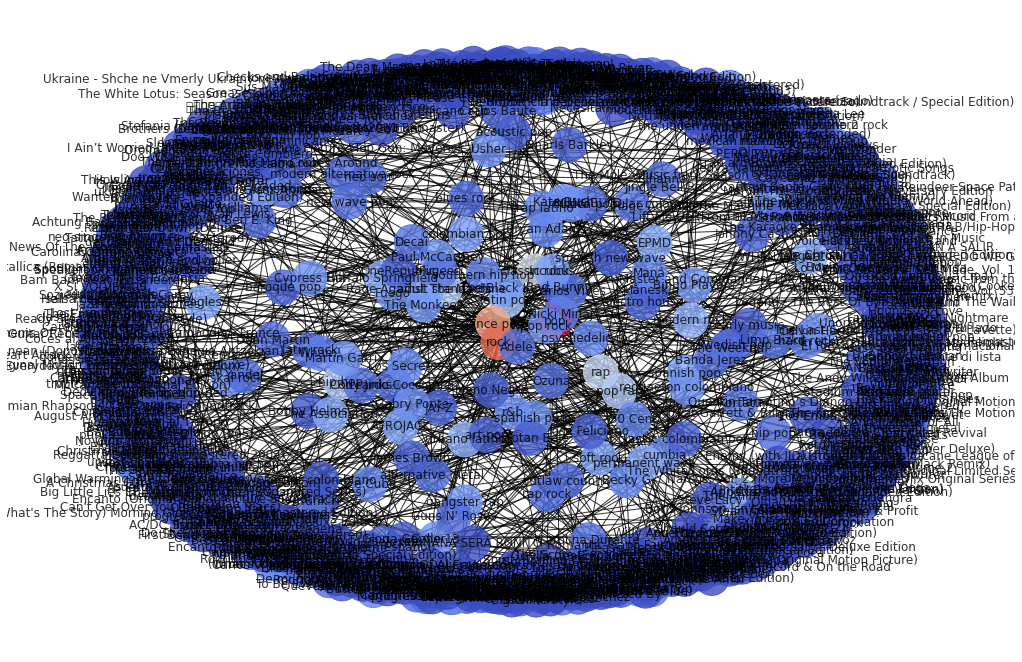

In [50]:
visualizacion_grafo(G,factor_spring_layout)

In [46]:
#ahora incluimos los nodos de las canciones escuchadas con sus aristas con los albums
for index, row in df_tracks_ids_final.iterrows():
    track_name = row['trackName']
    album_id = row['albumID']

    G.add_node(track_name,
               type=row['type'],
                id=row['trackName'],
               
               n_times_listen=row['n_times_listen'],
               n_min_played=row['n_min_played'],

               danceability=row['danceability'],
               energy=row['energy'],
               loudness=row['loudness'],
               speechiness=row['speechiness'],
               tempo=row['tempo'],

               uri=row['uri'])

    # vemos si hay algun nodo de artista que tenga ese id
    album_node = None
    for node, attr in G.nodes(data=True):
        if 'id' in attr and attr['type'] == 'album' and attr['id'] == album_id:
            album_node = node
            break

    # si existe entonces creamos la arista
    if album_node is not None:
        G.add_edge(track_name, album_node)

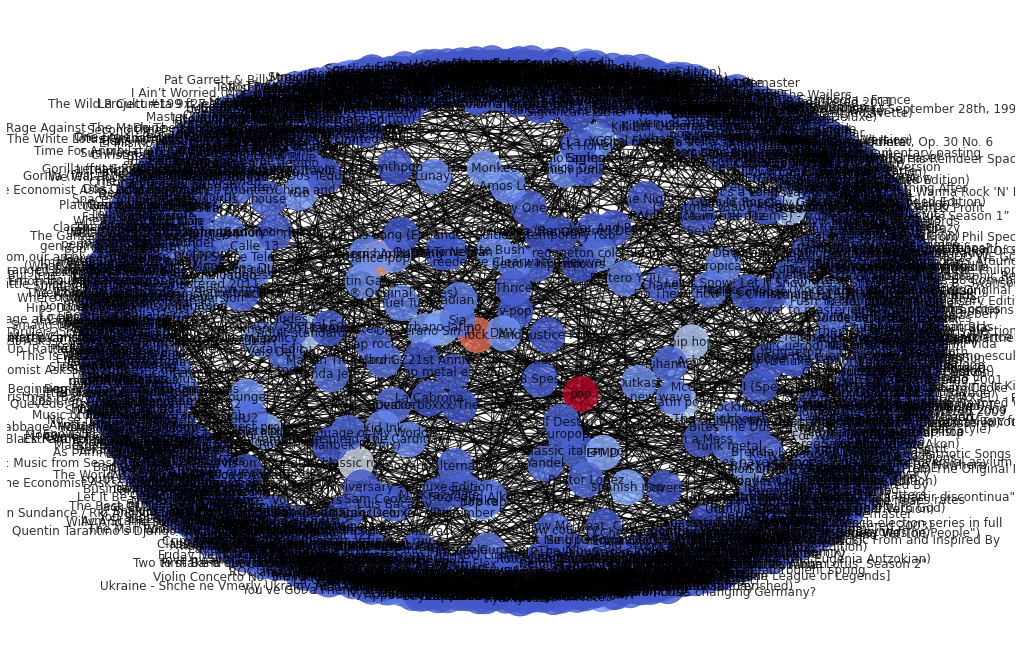

In [61]:
visualizacion_grafo(G,factor_spring_layout)

## Analisis del tamaño del grafo y redimmensionamiento

In [47]:
#miramos el numero de nodos que tiene
len(G.nodes())

1552

In [48]:
#miramos el numero de aristas que tiene
len(G.edges())

1321

Nos salen muchos nodos con lo que vamos a filtrar el numero de canciones a incluir y de ahi en cascada filtraremos hasta los generos

In [2]:
#df_tracks_ids_final=pd.read_csv('output/tracks_ids_final.csv')
#df_albums=pd.read_csv('output/album_ids.csv')
#df_artistas=pd.read_csv('output/artists_ids.csv')
#df_genres=pd.read_csv('output/genres_ids.csv')

nº de canciones escuchadas: 594
nº de canciones escuchadas una vez: 291
nº de canciones escuchadas mas de vez: 302


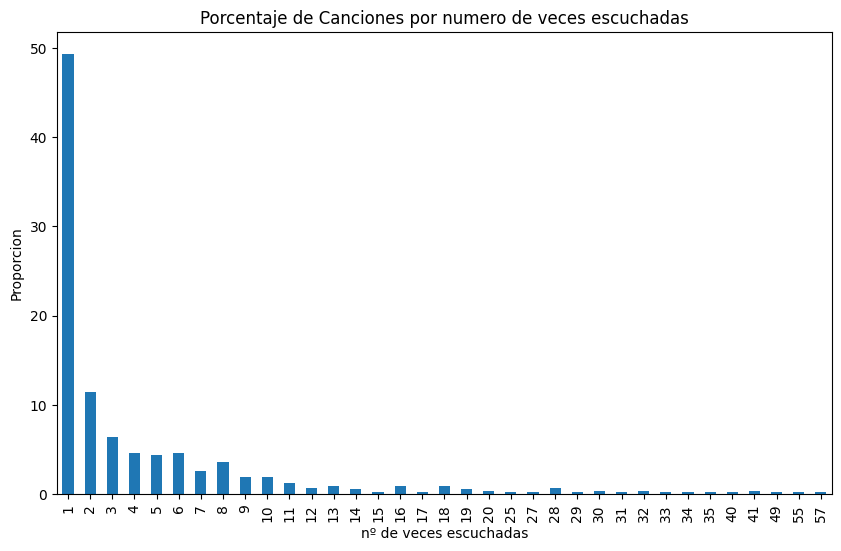

In [49]:
counts = df_tracks_ids_final['n_times_listen'].value_counts(normalize=True).sort_index()* 100

print("nº de canciones escuchadas: "+str(len(df_tracks_ids_final)))
print("nº de canciones escuchadas una vez: "+str(int(len(df_tracks_ids_final)*0.49)))
print("nº de canciones escuchadas mas de vez: "+str(int(len(df_tracks_ids_final)*0.51)))

# Plot the bar chart
plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.xlabel('nº de veces escuchadas')
plt.ylabel('Proporcion')
plt.title('Porcentaje de Canciones por numero de veces escuchadas')
plt.show()

Nos quedamos unicamente con las canciones que se han escuchado mas de una vez

In [50]:
df_tracks_ids_final_filtrado=df_tracks_ids_final[df_tracks_ids_final['n_times_listen']>1]
print("el nº de canciones sin filtrar: "+str(len(df_tracks_ids_final)))
print("el nº de canciones filtrados: "+str(len(df_tracks_ids_final_filtrado)))

el nº de canciones sin filtrar: 594
el nº de canciones filtrados: 301


In [51]:
#filtramos los albums
albumes_filtrados=list(set(df_tracks_ids_final_filtrado['albumID']))

df_albums_filtrados=df_albums[df_albums['id'].isin(albumes_filtrados)]
print("el nº de albums sin filtrar: "+str(len(df_albums)))
print("el nº de albums filtrados: "+str(len(df_albums_filtrados)))

el nº de albums sin filtrar: 478
el nº de albums filtrados: 256


In [52]:
#filtramos los artistas
#artistas_filtrados=list(set(df_albums_filtrados['artist_id']))
artistas_filtrados=list(set(df_tracks_ids_final_filtrado['artistName']))

#df_artistas_filtrados=df_artistas[df_artistas['id'].isin(artistas_filtrados)]
df_artistas_filtrados=df_artistas[df_artistas['name'].isin(artistas_filtrados)]
print("el nº de artistas sin filtrar: "+str(len(df_artistas)))
print("el nº de artistas filtrados: "+str(len(df_artistas_filtrados)))

el nº de artistas sin filtrar: 280
el nº de artistas filtrados: 164


In [53]:
#reducimos los generos
exploded_df = df_artistas_filtrados.explode('genres')
df_genres_filtrados = exploded_df['genres'].unique()
df_genres_filtrados = pd.DataFrame(df_genres_filtrados, columns=['genres'])
print("el nº de generos sin filtrar: "+str(len(df_genres)))
print("el nº de generos filtrados: "+str(len(df_genres_filtrados)))

el nº de generos sin filtrar: 320
el nº de generos filtrados: 232


La parte de los generos sigue siendo demasiado diversa porque a cada artista se le tiende a asignar varios generos por lo que nos vamos a quedar unicamente con el primero

In [54]:
df_first_genre=df_artistas_filtrados[['name','id','genres']]
df_first_genre['genres'] = df_artistas_filtrados['genres'].apply(lambda x: x[0] if len(x) > 0 else 'other')
df_first_genre=df_first_genre[['name','id','genres']]
df_first_genre

C:\Users\daniq\AppData\Local\Temp\ipykernel_18172\1634020032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_genre['genres'] = df_artistas_filtrados['genres'].apply(lambda x: x[0] if len(x) > 0 else 'other')


name                      id   
1              The Latin Brothers  2AiZXMqpVlCDnz3trZbWaK  \
3                        Ice Cube  3Mcii5XWf6E0lrY3Uky4cA   
5                        AFROJACK  4D75GcNG95ebPtNvoNVXhz   
6                    Luis Bacalov  4iy3JrFlBLHPvXqN1OcQS1   
8                     OneRepublic  5Pwc4xIPtQLFEnJriah9YJ   
..                            ...                     ...   
269                    The Weeknd  1Xyo4u8uXC1ZmMpatF05PJ   
271              Norman Greenbaum  7f8LNBVXN0h35veHrpxQFL   
274                      38 Spesh  32cT1WQRSDg4xsReG7eqyT   
277  Creedence Clearwater Revival  3IYUhFvPQItj6xySrBmZkd   
279              Luigi Boccherini  2l4vGfFV7e46yO8lxfxR76   

                        genres  
1                        salsa  
3            conscious hip hop  
5                     big room  
6           classic soundtrack  
8                    dance pop  
..                         ...  
269  canadian contemporary r&b  
271               classic rock  
274                   boom bap  
277                 album rock  
279                  classical  

[164 rows x 3 columns]

In [55]:
len(set(list(df_first_genre['genres'])))

99

In [56]:
unique_genres = df_first_genre['genres'].dropna().unique()
type(unique_genres)

numpy.ndarray

In [57]:
combined_genres = ', '.join(unique_genres)
combined_genres

'salsa, conscious hip hop, big room, classic soundtrack, dance pop, rock-and-roll, roots rock, classic colombian pop, alternative rock, spanish pop, alternative metal, grunge, euskal rock, vallenato, chanson, acoustic rock, pop rap, classic soul, chillwave, album rock, reggaeton, detroit hip hop, modern rock, punk urbano, modern alternative rock, cumbia, cali rap, other, hip hop, colombian pop, latin afrobeat, pop, basque folk, blues, uk pop, neo mellow, indie rock, french rock, pop soul, beach music, belgian pop, hard rock, garage rock, indie rock italiano, east coast hip hop, latin pop, mambo, late romantic era, post-hardcore, new wave pop, chicano rap, classic rock, adult standards, spanish indie pop, latin arena pop, canadian hip hop, atl hip hop, puerto rican pop, neo soul, ska, afro r&b, bubblegum pop, flamenco guitar, euskal metal, miami hip hop, classical, art pop, barbadian pop, australian rock, bhangra, boston punk, funk, canadian punk, gauze pop, beatlesque, canadian soundtr

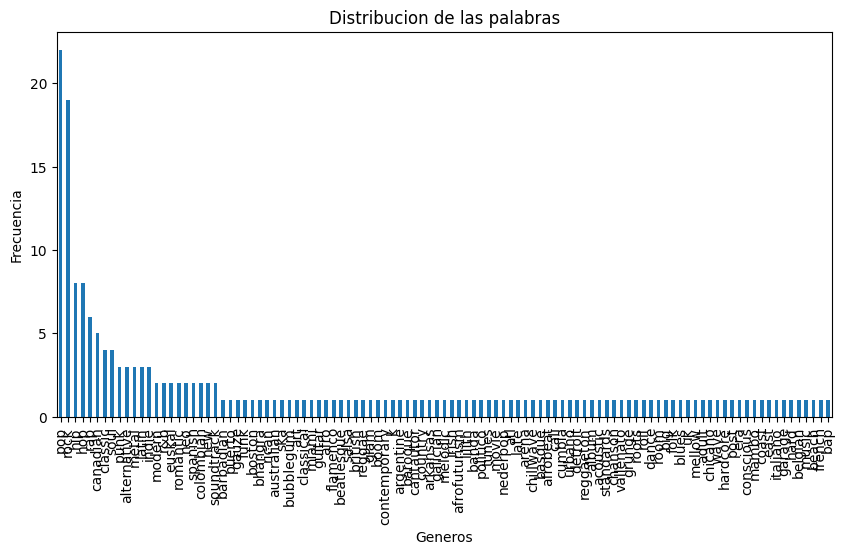

In [58]:
nlp = spacy.load("en_core_web_sm")

words = [token.text for token in nlp(combined_genres) if (not token.is_stop and not token.is_punct)]

word_freq = Counter(words)

# Create a DataFrame from the word frequencies
df_word_freq = pd.DataFrame.from_dict(word_freq, orient="index", columns=["Frequency"])

# Sort the DataFrame by frequency
df_word_freq.sort_values(by="Frequency", ascending=False, inplace=True)

# Plot the bar chart
ax = df_word_freq.plot(kind="bar", figsize=(10, 5), legend=False)
ax.set_xlabel("Generos")
ax.set_ylabel("Frecuencia")
ax.set_title("Distribucion de las palabras")
plt.show()

In [59]:
#creamos un diccionario con los valores vacios y los asignamos manualmente nosotros al no ser tantos:
{genre: " " for genre in df_first_genre['genres'].dropna().unique()}

{'salsa': ' ',
 'conscious hip hop': ' ',
 'big room': ' ',
 'classic soundtrack': ' ',
 'dance pop': ' ',
 'rock-and-roll': ' ',
 'roots rock': ' ',
 'classic colombian pop': ' ',
 'alternative rock': ' ',
 'spanish pop': ' ',
 'alternative metal': ' ',
 'grunge': ' ',
 'euskal rock': ' ',
 'vallenato': ' ',
 'chanson': ' ',
 'acoustic rock': ' ',
 'pop rap': ' ',
 'classic soul': ' ',
 'chillwave': ' ',
 'album rock': ' ',
 'reggaeton': ' ',
 'detroit hip hop': ' ',
 'modern rock': ' ',
 'punk urbano': ' ',
 'modern alternative rock': ' ',
 'cumbia': ' ',
 'cali rap': ' ',
 'other': ' ',
 'hip hop': ' ',
 'colombian pop': ' ',
 'latin afrobeat': ' ',
 'pop': ' ',
 'basque folk': ' ',
 'blues': ' ',
 'uk pop': ' ',
 'neo mellow': ' ',
 'indie rock': ' ',
 'french rock': ' ',
 'pop soul': ' ',
 'beach music': ' ',
 'belgian pop': ' ',
 'hard rock': ' ',
 'garage rock': ' ',
 'indie rock italiano': ' ',
 'east coast hip hop': ' ',
 'latin pop': ' ',
 'mambo': ' ',
 'late romantic era': 

In [60]:
mapeo_generos={'australian rock': 'rock', 'garage rock': 'rock', 'cumbia': 'latino','alternative metal': 'rock', 'grunge': 'rock',
 'french rock': 'rock', 'adult standards': 'rock', 'art pop': 'pop', 'ska': 'rock', 'rap politico': 'hip hop', 'colombian pop': 'pop',
 'african rock': 'rock', 'piano rock': 'pop', 'pop': 'pop', 'afro r&b': 'pop', 'miami hip hop': 'hip hop', 'vallenato': 'latino',
 'classic rock': 'rock', 'uk pop': 'pop', 'mambo': 'latino', 'modern rock': 'rock', 'euskal rock': 'rock', 'belgian pop': 'pop',
 'latin afrobeat': 'reggaeton', 'argentine hip hop': 'hip hop', 'afrofuturism': 'rock', 'glam metal': 'rock', 'post-hardcore': 'rock',
'album rock': 'rock', 'alternative rock':'rock', 'atl hip hop': 'hip hop', 'alternative hip hop': 'hip hop', 'big room': 'dance',
 'permanent wave': 'rock', 'chillwave': 'dance', 'detroit hip hop': 'hip hop', 'irish rock': 'rock', 'flamenco guitar': 'classical',
 'beatlesque': 'rock', 'euskal metal': 'rock', 'indie rock italiano': 'rock', 'pop rap': 'hip hop', 'reggaeton': 'reggaeton',
 'reggae': 'rock', 'cantautor': 'rock', 'gauze pop': 'pop', 'east coast hip hop': 'hip hop', 'british soul': 'pop',
 'dance pop': 'pop', 'boom bap': 'hip hop', 'blues rock':'rock', 'galician rock': 'rock', 'latin rock': 'rock',
 'banda': 'latino','other':'other', 'beach music': 'rock', 'british invasion': 'rock', 'canadian hip hop': 'hip hop', 'acoustic rock': 'rock',
'latin arena pop':'pop', 'indie pop': 'pop', 'hard rock': 'rock', 'neo soul': 'pop', 'puerto rican pop': 'pop',
 'classic colombian pop': 'pop', 'canadian contemporary r&b': 'pop', 'bhangra': 'hip hop', 'k-pop': 'pop', 'barbadian pop': 'pop',
 'cali rap': 'hip hop', 'roots rock':'rock', 'chanson': 'pop', 'bubblegum pop': 'pop', 'canadian soundtrack': 'pop', 'canadian punk': 'rock',
 'boston punk': 'rock', 'basque folk': 'rock', 'viral pop': 'pop', 'melodic rap': 'hip hop', 'disco': 'pop', 'hip pop': 'hip hop', 'rock-and-roll': 'rock',
 'funk': 'rock', 'spanish pop': 'pop', 'conscious hip hop': 'hip hop', 'arkansas country': 'rock', 'chicano rap': 'hip hop',
 'hip hop': 'hip hop','classical':'classical','classic soundtrack': 'pop','late romantic era':'classical',
 'latin viral pop':'latino','canadian pop':'rock','punk urbano':'rock','modern alternative rock':'rock','pop soul':'pop','classic soul':'pop','nederpop':'pop','movie tunes':'pop','salsa':'latino','neo mellow':'rock','lilith':'rock','rap rock': 'hip hop','pop rock':'rock','latin pop':'latino','baroque pop':'rock','spanish indie pop':'rock','blues':'rock','new wave pop':'pop','new romantic':'rock','indie rock':'rock'
}

In [289]:
#Utilizamos el codigo de abajo para hacer filtros para ver ese genero a cual mapearlo
#df_first_genre[df_first_genre['genres']=='piano rock']
df_artistas[df_artistas['name']=='Wolfgang Amadeus Mozart']
#df_artistas_filtrados[df_artistas_filtrados['name']=='Wolfgang Amadeus Mozart']
#df_tracks_ids_final[df_tracks_ids_final['artistName']=='Vladsta']
#df_first_genre[df_first_genre['name']=='Wolfgang Amadeus Mozart']
#df_first_genre

name  followers                               genres  \
277  Wolfgang Amadeus Mozart  4951829.0  [classical, classical era, lullaby]   

                         id  \
277  4NJhFmfw43RLBLjQvxDuRS   

                                                image1  \
277  https://i.scdn.co/image/ab6761610000e5eb7fa910...   

                                                image2  \
277  https://i.scdn.co/image/ab676161000051747fa910...   

                                                image3  popularity    type  \
277  https://i.scdn.co/image/ab6761610000f1787fa910...        76.0  artist   

                                       uri  
277  spotify:artist:4NJhFmfw43RLBLjQvxDuRS

In [61]:
df_first_genre['final_genres'] = df_first_genre['genres'].apply(lambda x: mapeo_generos.get(x, "other"))

In [62]:
list(df_first_genre['final_genres'].unique())

['latino',
 'hip hop',
 'dance',
 'pop',
 'rock',
 'reggaeton',
 'other',
 'classical']

In [63]:
#miramos cuales caen en other
df_first_genre[df_first_genre['final_genres'].isin(["other"])]

name                      id genres final_genres
72       Mason Williams  1XgVoPT2Va5L64LFzskVBW  other        other
82              Vladsta  3RWrARiknL6w2XUbCS61h9  other        other
128       Marc Rebillet  72udTJKu1pGovvS9aCYGMI  other        other
149         Mark Ronson  3hv9jJF3adDNsBSIQDqcjp  other        other
171  Vallenatos Nativos  5SdcPt2f884fB3DITvFqok  other        other

In [64]:
#modificamos los other a lo que creemos
for index, row in df_first_genre.iterrows():
    if row['final_genres'] == 'other':
        
        if row['name'] == 'Vallenatos Nativos':
            df_first_genre.at[index, 'final_genres'] = 'latino'
            
        elif row['name'] == 'Marc Rebillet':
            df_first_genre.at[index, 'final_genres'] = 'hip hop'
                        
        elif row['name'] == 'Mason Williams':
            df_first_genre.at[index, 'final_genres'] = 'rock'
            
        elif row['name'] == 'Vladsta':
            df_first_genre.at[index, 'final_genres'] = 'hip hop'

        elif row['name'] == 'Mark Ronson':
            df_first_genre.at[index, 'final_genres'] = 'pop'




print(df_first_genre[df_first_genre['final_genres'].isin(["other"])])
print(df_first_genre['final_genres'].unique())

Empty DataFrame
Columns: [name, id, genres, final_genres]
Index: []
['latino' 'hip hop' 'dance' 'pop' 'rock' 'reggaeton' 'classical']


In [65]:
#sacamos los generos filtrados
df_genres_filtrados = df_first_genre['final_genres'].unique()
df_genres_filtrados = pd.DataFrame(df_genres_filtrados, columns=['genres'])
df_genres_filtrados

genres
0     latino
1    hip hop
2      dance
3        pop
4       rock
5  reggaeton
6  classical

In [66]:
#añadimos a los generos una imagen
for index, row in df_genres_filtrados.iterrows():
    if row['genres'] == 'rock':
            df_genres_filtrados.at[index, 'image'] = "https://c8.alamy.com/compes/k6ry0r/la-musica-rock-rotulacion-guitarra-fretboard-etiqueta-ilustracion-vectorial-k6ry0r.jpg"
    if row['genres'] == 'pop':
            df_genres_filtrados.at[index, 'image'] = "https://c8.alamy.com/compes/2amt118/letras-de-vector-3d-vintage-de-musica-pop-fuente-retro-negrita-tipo-de-letra-texto-estilizado-del-arte-pop-letras-de-estilo-de-la-vieja-escuela-90s-poster-de-los-80s-banner-la-mitad-azul-2amt118.jpg"
    if row['genres'] == 'latino':
            df_genres_filtrados.at[index, 'image'] = "https://img.freepik.com/vector-premium/ilustracion-banda-musica-latina-dibujada-mano_52683-91269.jpg"
    if row['genres'] == 'hip hop':
            df_genres_filtrados.at[index, 'image'] = "https://img.freepik.com/premium-vector/hip-hop-style-t-shirt-design_9645-1054.jpg"
    if row['genres'] == 'dance':
            df_genres_filtrados.at[index, 'image'] = "https://www.shutterstock.com/shutterstock/photos/1143150974/display_1500/stock-vector-electronic-dance-music-vector-illustration-1143150974.jpg"
    if row['genres'] == 'reggaeton':
            df_genres_filtrados.at[index, 'image'] = "https://i1.sndcdn.com/avatars-000738721705-qhfhiy-t500x500.jpg"
    if row['genres'] == 'classical':
            df_genres_filtrados.at[index, 'image'] = "https://upload.wikimedia.org/wikipedia/commons/7/78/Classic_music.jpg"         

In [67]:
df_genres_filtrados

genres                                              image
0     latino  https://img.freepik.com/vector-premium/ilustra...
1    hip hop  https://img.freepik.com/premium-vector/hip-hop...
2      dance  https://www.shutterstock.com/shutterstock/phot...
3        pop  https://c8.alamy.com/compes/2amt118/letras-de-...
4       rock  https://c8.alamy.com/compes/k6ry0r/la-musica-r...
5  reggaeton  https://i1.sndcdn.com/avatars-000738721705-qhf...
6  classical  https://upload.wikimedia.org/wikipedia/commons...

In [68]:
print(len(df_first_genre))
df_first_genre=df_first_genre.drop_duplicates(subset=['id'])
print(len(df_first_genre.drop_duplicates(subset=['id'])))

164
158


In [69]:
print("las filas de artistas antes del cruce son: "+str(len(df_artistas_filtrados)))
df_artistas_filtrados = (
    pd.merge(df_artistas_filtrados.drop("genres", axis=1), df_first_genre.drop(columns=['id','genres']), on='name', how='left')
    .drop_duplicates(subset=['uri'])
    .rename(columns={'final_genres':'genres'})
    )
print("las filas de artistas despues del cruce son: "+str(len(df_artistas_filtrados)))
df_artistas_filtrados

las filas de artistas antes del cruce son: 164
las filas de artistas despues del cruce son: 158


name   followers                      id   
0              The Latin Brothers    201709.0  2AiZXMqpVlCDnz3trZbWaK  \
1                        Ice Cube   6792994.0  3Mcii5XWf6E0lrY3Uky4cA   
2                        AFROJACK   3982534.0  4D75GcNG95ebPtNvoNVXhz   
3                    Luis Bacalov     26085.0  4iy3JrFlBLHPvXqN1OcQS1   
4                     OneRepublic  15387229.0  5Pwc4xIPtQLFEnJriah9YJ   
..                            ...         ...                     ...   
159                    The Weeknd  62873991.0  1Xyo4u8uXC1ZmMpatF05PJ   
160              Norman Greenbaum     61489.0  7f8LNBVXN0h35veHrpxQFL   
161                      38 Spesh     44941.0  32cT1WQRSDg4xsReG7eqyT   
162  Creedence Clearwater Revival   5691476.0  3IYUhFvPQItj6xySrBmZkd   
163              Luigi Boccherini    101327.0  2l4vGfFV7e46yO8lxfxR76   

                                                image1   
0    https://i.scdn.co/image/ab67616d0000b2734990e3...  \
1    https://i.scdn.co/image/ab6761610000e5eb650e79...   
2    https://i.scdn.co/image/ab6761610000e5eb78484e...   
3    https://i.scdn.co/image/a961ac3d889ed95dc1a439...   
4    https://i.scdn.co/image/ab6761610000e5eb77bf00...   
..                                                 ...   
159  https://i.scdn.co/image/ab6761610000e5ebb5f9e2...   
160  https://i.scdn.co/image/0eb947b89f490acd881efd...   
161  https://i.scdn.co/image/ab6761610000e5eb05d9fd...   
162  https://i.scdn.co/image/ab6761610000e5ebd2e2b0...   
163  https://i.scdn.co/image/817aecce7df6ff9d28a1be...   

                                                image2   
0    https://i.scdn.co/image/ab67616d00001e024990e3...  \
1    https://i.scdn.co/image/ab67616100005174650e79...   
2    https://i.scdn.co/image/ab6761610000517478484e...   
3    https://i.scdn.co/image/7eedb0df6d55f039d086c0...   
4    https://i.scdn.co/image/ab6761610000517477bf00...   
..                                                 ...   
159  https://i.scdn.co/image/ab67616100005174b5f9e2...   
160  https://i.scdn.co/image/86d4fa144d367e1fc7111a...   
161  https://i.scdn.co/image/ab6761610000517405d9fd...   
162  https://i.scdn.co/image/ab67616100005174d2e2b0...   
163  https://i.scdn.co/image/06702e382a7515fa3b059f...   

                                                image3  popularity    type   
0    https://i.scdn.co/image/ab67616d000048514990e3...        49.0  artist  \
1    https://i.scdn.co/image/ab6761610000f178650e79...        76.0  artist   
2    https://i.scdn.co/image/ab6761610000f17878484e...        73.0  artist   
3    https://i.scdn.co/image/e1c5414cb2468a5b8d62cc...        47.0  artist   
4    https://i.scdn.co/image/ab6761610000f17877bf00...        84.0  artist   
..                                                 ...         ...     ...   
159  https://i.scdn.co/image/ab6761610000f178b5f9e2...        97.0  artist   
160  https://i.scdn.co/image/d510f1f9edb3225c520c49...        57.0  artist   
161  https://i.scdn.co/image/ab6761610000f17805d9fd...        50.0  artist   
162  https://i.scdn.co/image/ab6761610000f178d2e2b0...        80.0  artist   
163  https://i.scdn.co/image/bd30be0f8245083c38b651...        51.0  artist   

                                       uri     genres  
0    spotify:artist:2AiZXMqpVlCDnz3trZbWaK     latino  
1    spotify:artist:3Mcii5XWf6E0lrY3Uky4cA    hip hop  
2    spotify:artist:4D75GcNG95ebPtNvoNVXhz      dance  
3    spotify:artist:4iy3JrFlBLHPvXqN1OcQS1        pop  
4    spotify:artist:5Pwc4xIPtQLFEnJriah9YJ        pop  
..                                     ...        ...  
159  spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ        pop  
160  spotify:artist:7f8LNBVXN0h35veHrpxQFL       rock  
161  spotify:artist:32cT1WQRSDg4xsReG7eqyT    hip hop  
162  spotify:artist:3IYUhFvPQItj6xySrBmZkd       rock  
163  spotify:artist:2l4vGfFV7e46yO8lxfxR76  classical  

[158 rows x 10 columns]

In [70]:
#como vamos a cruzar por esta variable nos aseguramos que no hay duplicados
print(len(df_artistas_filtrados['name'].unique()))
print(len(df_artistas_filtrados['id'].unique()))
print(len(df_artistas_filtrados['uri'].unique()))

158
158
158


In [71]:
print(len(df_tracks_ids_final_filtrado['artistName'].unique()))

166


In [72]:
# los convertimos en sets
set_artistas = set(df_artistas_filtrados['name'])
set_tracks = set(df_tracks_ids_final_filtrado['artistName'])

# miramos las diferencias
diff_artistas_not_in_tracks = set_artistas.difference(set_tracks)
diff_tracks_not_in_artistas = set_tracks.difference(set_artistas)

print("Levels in 'name' not in 'artistName':", diff_artistas_not_in_tracks)
print("Levels in 'artistName' not in 'name':", diff_tracks_not_in_artistas)

Levels in 'name' not in 'artistName': set()
Levels in 'artistName' not in 'name': {'Will Smith', 'Voice Of Destruction', 'Hamlet', 'The Economist Podcasts', 'Frente!', 'La Caja de Pandora. Historia', 'Más de uno', 'Marea'}


Estos artistas nunca se recuperaron de la lista de artistas de Spotify. La mayoria eran podcasts pero hay otros que igual son poco conocidos como 'Will Smith', 'Marea' o 'Hamlet'.

Es por ello que procedemos a eliminarlos de la lista de canciones

In [73]:
df_tracks_ids_final_filtrado = (df_tracks_ids_final_filtrado[~df_tracks_ids_final_filtrado['artistName'].
                                                             isin(list(diff_tracks_not_in_artistas))]
                               )

Volvemos a comprobar que ahora no salgan en ninguna de las dos

In [74]:
# los convertimos en sets
set_artistas = set(df_artistas_filtrados['name'])
set_tracks = set(df_tracks_ids_final_filtrado['artistName'])

# miramos las diferencias
diff_artistas_not_in_tracks = set_artistas.difference(set_tracks)
diff_tracks_not_in_artistas = set_tracks.difference(set_artistas)

print("Levels in 'name' not in 'artistName':", diff_artistas_not_in_tracks)
print("Levels in 'artistName' not in 'name':", diff_tracks_not_in_artistas)

Levels in 'name' not in 'artistName': set()
Levels in 'artistName' not in 'name': set()


Por ultimo comprobamos que no hay duplicado en ninguno de los df

In [75]:
df_tracks_ids_final_filtrado[df_tracks_ids_final_filtrado['trackName'].duplicated(keep=False)]

uri  n_times_listen  n_min_played   
2389  spotify:track:6dSKiwCqJbpFZIwFB2tkru               5     16.910200  \
1307  spotify:track:3Dw69iKKgj2U3JzeeftBbx               4      4.049391   

              artistName    trackName  danceability  energy  key  loudness   
2389        Pastor Lopez  Traicionera         0.800   0.608    2    -5.041  \
1307  Vallenatos Nativos  Traicionera         0.787   0.540    2    -6.973   

      mode  ...  valence    tempo   type                      id   
2389     1  ...    0.963  130.002  track  6dSKiwCqJbpFZIwFB2tkru  \
1307     1  ...    0.967  129.949  track  3Dw69iKKgj2U3JzeeftBbx   

                                             track_href   
2389  https://api.spotify.com/v1/tracks/6dSKiwCqJbpF...  \
1307  https://api.spotify.com/v1/tracks/3Dw69iKKgj2U...   

                                           analysis_url duration_ms   
2389  https://api.spotify.com/v1/audio-analysis/6dSK...      209816  \
1307  https://api.spotify.com/v1/audio-analysis/3Dw6...      214840   

     time_signature              albumName                 albumID  
2389              4  Música Que Trasciende  1bEUIyKIIIru7gbBX5Gb4Y  
1307              4       Latin Vallenatos  0uWkTYkohs30DzAhSMIf3D  

[2 rows x 24 columns]

In [76]:
#modificamos el duplicado que nos habia dado
for index, row in df_tracks_ids_final_filtrado.iterrows():
    if row['artistName'] == 'Pastor Lopez':
        if row['trackName'] == 'Traicionera':
            df_tracks_ids_final_filtrado.at[index, 'trackName'] = 'Traicionera PL'

df_tracks_ids_final_filtrado[df_tracks_ids_final_filtrado['trackName'].duplicated(keep=False)]

Empty DataFrame
Columns: [uri, n_times_listen, n_min_played, artistName, trackName, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, type, id, track_href, analysis_url, duration_ms, time_signature, albumName, albumID]
Index: []

[0 rows x 24 columns]

In [77]:
df_genres_filtrados[df_genres_filtrados['genres'].duplicated(keep=False)]

Empty DataFrame
Columns: [genres, image]
Index: []

In [78]:
df_artistas_filtrados[df_artistas_filtrados['name'].duplicated(keep=False)]

Empty DataFrame
Columns: [name, followers, id, image1, image2, image3, popularity, type, uri, genres]
Index: []

**Incluimos el numero de veces que un artista lo hemos eschuchado en funcion de las canciones que tiene**

In [79]:
result=df_tracks_ids_final_filtrado.groupby('artistName')['n_times_listen'].agg([("suma","sum"),("conteo","count")])
result['n_times_listen'] = result['suma'] / result['conteo']
result = result.reset_index().rename(columns={'artistName': 'name'}).drop(columns=['suma', 'conteo'])
result

name  n_times_listen
0                   38 Spesh        4.000000
1                      AC/DC        6.000000
2                   AFROJACK        6.000000
3                      Adele        5.000000
4                  Airbourne        2.333333
..                       ...             ...
153              Wiz Khalifa        7.000000
154               Wolf Alice        2.000000
155  Wolfgang Amadeus Mozart        3.000000
156                       YG        4.000000
157                will.i.am       13.000000

[158 rows x 2 columns]

In [80]:
df_tracks_ids_final_filtrado['n_times_listen'].max()

57

In [81]:
print("nº de filas antes de cruzar: "+str(len(df_artistas_filtrados)))
df_artistas_filtrados = pd.merge(df_artistas_filtrados, result, on='name', how='left')
print("nº de filas antes de cruzar: "+str(len(df_artistas_filtrados)))

nº de filas antes de cruzar: 158
nº de filas antes de cruzar: 158


In [82]:
df_artistas_filtrados.head(5)

name   followers                      id   
0  The Latin Brothers    201709.0  2AiZXMqpVlCDnz3trZbWaK  \
1            Ice Cube   6792994.0  3Mcii5XWf6E0lrY3Uky4cA   
2            AFROJACK   3982534.0  4D75GcNG95ebPtNvoNVXhz   
3        Luis Bacalov     26085.0  4iy3JrFlBLHPvXqN1OcQS1   
4         OneRepublic  15387229.0  5Pwc4xIPtQLFEnJriah9YJ   

                                              image1   
0  https://i.scdn.co/image/ab67616d0000b2734990e3...  \
1  https://i.scdn.co/image/ab6761610000e5eb650e79...   
2  https://i.scdn.co/image/ab6761610000e5eb78484e...   
3  https://i.scdn.co/image/a961ac3d889ed95dc1a439...   
4  https://i.scdn.co/image/ab6761610000e5eb77bf00...   

                                              image2   
0  https://i.scdn.co/image/ab67616d00001e024990e3...  \
1  https://i.scdn.co/image/ab67616100005174650e79...   
2  https://i.scdn.co/image/ab6761610000517478484e...   
3  https://i.scdn.co/image/7eedb0df6d55f039d086c0...   
4  https://i.scdn.co/image/ab6761610000517477bf00...   

                                              image3  popularity    type   
0  https://i.scdn.co/image/ab67616d000048514990e3...        49.0  artist  \
1  https://i.scdn.co/image/ab6761610000f178650e79...        76.0  artist   
2  https://i.scdn.co/image/ab6761610000f17878484e...        73.0  artist   
3  https://i.scdn.co/image/e1c5414cb2468a5b8d62cc...        47.0  artist   
4  https://i.scdn.co/image/ab6761610000f17877bf00...        84.0  artist   

                                     uri   genres  n_times_listen  
0  spotify:artist:2AiZXMqpVlCDnz3trZbWaK   latino            16.0  
1  spotify:artist:3Mcii5XWf6E0lrY3Uky4cA  hip hop             8.0  
2  spotify:artist:4D75GcNG95ebPtNvoNVXhz    dance             6.0  
3  spotify:artist:4iy3JrFlBLHPvXqN1OcQS1      pop             4.0  
4  spotify:artist:5Pwc4xIPtQLFEnJriah9YJ      pop            40.0

**Añadimos las imagenes de los albums a las canciones**

In [83]:
df_albums_filtrados_cruze=df_albums_filtrados[['id','image3']].rename(columns={'id': 'albumID','image3': 'image'})
print("nº de filas antes de cruzar: "+str(len(df_tracks_ids_final_filtrado)))
df_tracks_ids_final_filtrado = pd.merge(df_tracks_ids_final_filtrado, df_albums_filtrados_cruze, on='albumID', how='left')
print("nº de filas antes de cruzar: "+str(len(df_tracks_ids_final_filtrado)))
df_tracks_ids_final_filtrado.head(5)

nº de filas antes de cruzar: 278
nº de filas antes de cruzar: 278


uri  n_times_listen  n_min_played   
0  spotify:track:20OFwXhEXf12DzwXmaV7fj              57     97.497828  \
1  spotify:track:7HTX5cE4qzHALfgO2xSvMd              55    206.703463   
2  spotify:track:2SJ38LDlkNjwWSUq98r4Q5              49     81.102562   
3  spotify:track:7aKXQCV7TaA56bnhXTxJFn              41    149.229115   
4  spotify:track:1eT2CjXwFXNx6oY5ydvzKU              41     88.755961   

                     artistName        trackName  danceability  energy  key   
0  Creedence Clearwater Revival  Bad Moon Rising         0.508   0.774    2  \
1                         Milow   Ayo Technology         0.778   0.661   11   
2                       Nirvana            Polly         0.830   0.382    2   
3                   Ayax y Prok        Reproches         0.696   0.909    4   
4                   The Beatles         Hey Jude         0.462   0.632    5   

   loudness  mode  ...    tempo   type                      id   
0    -5.973     1  ...  178.946  track  20OFwXhEXf12DzwXmaV7fj  \
1    -7.664     0  ...  128.052  track  7HTX5cE4qzHALfgO2xSvMd   
2   -11.231     0  ...  121.120  track  2SJ38LDlkNjwWSUq98r4Q5   
3    -6.943     1  ...   93.123  track  7aKXQCV7TaA56bnhXTxJFn   
4    -7.438     1  ...   74.268  track  1eT2CjXwFXNx6oY5ydvzKU   

                                          track_href   
0  https://api.spotify.com/v1/tracks/20OFwXhEXf12...  \
1  https://api.spotify.com/v1/tracks/7HTX5cE4qzHA...   
2  https://api.spotify.com/v1/tracks/2SJ38LDlkNjw...   
3  https://api.spotify.com/v1/tracks/7aKXQCV7TaA5...   
4  https://api.spotify.com/v1/tracks/1eT2CjXwFXNx...   

                                        analysis_url  duration_ms   
0  https://api.spotify.com/v1/audio-analysis/20OF...       141600  \
1  https://api.spotify.com/v1/audio-analysis/7HTX...       213640   
2  https://api.spotify.com/v1/audio-analysis/2SJ3...       173853   
3  https://api.spotify.com/v1/audio-analysis/7aKX...       273548   
4  https://api.spotify.com/v1/audio-analysis/1eT2...       238854   

  time_signature                       albumName                 albumID   
0              4  Green River (Expanded Edition)  0i9mOB6mPGqwVvtJEXiwPG  \
1              4         Acoustic Dance Sessions  5ra1FnP7de0jb5q47esf8u   
2              4          Nevermind (Remastered)  2UJcKiJxNryhL050F5Z1Fk   
3              4                       Reproches  2z4I2HXUaqMlxprZfXJ0qe   
4              4                            Love  1Ye7yrA7vAlQnoooj8yDXb   

                                               image  
0  https://i.scdn.co/image/ab67616d000048513efcd2...  
1  https://i.scdn.co/image/ab67616d00004851ff2a73...  
2  https://i.scdn.co/image/ab67616d00004851fbc71c...  
3  https://i.scdn.co/image/ab67616d00004851610060...  
4  https://i.scdn.co/image/ab67616d0000485130503d...  

[5 rows x 25 columns]

In [84]:
df_genres_filtrados

genres                                              image
0     latino  https://img.freepik.com/vector-premium/ilustra...
1    hip hop  https://img.freepik.com/premium-vector/hip-hop...
2      dance  https://www.shutterstock.com/shutterstock/phot...
3        pop  https://c8.alamy.com/compes/2amt118/letras-de-...
4       rock  https://c8.alamy.com/compes/k6ry0r/la-musica-r...
5  reggaeton  https://i1.sndcdn.com/avatars-000738721705-qhf...
6  classical  https://upload.wikimedia.org/wikipedia/commons...

**Volvemos a crear el grafo habiendo reducido considerablemente los nodos**

Hemos hecho los siguiente:
+ Quitado las canciones que solo se han escuchado una vez
+ Quitado los nodos de los albums y haremos aristas directamente de canciones a artistas
+ Reducido considerablemente el numero de generos musicales haciendo una agrupacion manual a suprageneros

In [87]:
# guardamos los ficheros y los recuperamos
#df_genres_filtrados.to_csv('output/df_genres_filtrados.csv')
#df_artistas_filtrados.to_csv('output/df_artistas_filtrados.csv')
#df_tracks_ids_final_filtrado.to_csv('output/df_tracks_ids_final_filtrado.csv')

df_genres_filtrados=pd.read_csv('output/df_genres_filtrados.csv')
df_artistas_filtrados=pd.read_csv('output/df_artistas_filtrados.csv')
df_tracks_ids_final_filtrado=pd.read_csv('output/df_tracks_ids_final_filtrado.csv')

In [88]:
G = nx.Graph()

In [89]:
#incluimos los nodos de genero musical
for index, row in df_genres_filtrados.iterrows():
    genre = row['genres']
    G.add_node(genre,
               id=genre,
               image=row['image'],
               type='genre')

In [90]:
print("nº de generos: "+str(len(df_genres_filtrados)))
print("nº de nodos: "+str(len(G.nodes())))
print("nº de aristas: "+str(len(G.edges())))

nº de generos: 7
nº de nodos: 7
nº de aristas: 0


In [91]:
#ahora incluimos los nodos de los artistas con sus aristas con los generos
for index, row in df_artistas_filtrados.iterrows():
    artist_name = row['name']

    G.add_node(artist_name,
               image=row['image3'],
               id=artist_name,
               n_times_listen=row['n_times_listen'],
               type=row['type'],
               followers=row['followers'],
               popularity=row['popularity'],
               uri=row['uri'])

    # ahora creamos las aristas con los generos
    if row['genres'] in G.nodes:
            G.add_edge(artist_name, row['genres'])

In [92]:
print("nº de artistas: "+str(len(df_artistas_filtrados)))
print("nº de nodos: "+str(len(G.nodes())))
print("nº de aristas: "+str(len(G.edges())))

nº de artistas: 158
nº de nodos: 165
nº de aristas: 158


In [93]:
#ahora incluimos los nodos de las canciones escuchadas con sus aristas con los albums
for index, row in df_tracks_ids_final_filtrado.iterrows():
    track_name = row['trackName']

    G.add_node(track_name,
               type=row['type'],
               id=track_name,
               
               n_times_listen=row['n_times_listen'],
               n_min_played=row['n_min_played'],

               danceability=row['danceability'],
               energy=row['energy'],
               loudness=row['loudness'],
               speechiness=row['speechiness'],
               tempo=row['tempo'],

               image=row['image'],
               uri=row['uri'])

    # ahora creamos las aristas con los artistas
    if row['artistName'] in G.nodes:
            G.add_edge(track_name, row['artistName'])

In [94]:
print("nº de canciones: "+str(len(df_tracks_ids_final_filtrado)))
print("nº de nodos: "+str(len(G.nodes())))
print("nº de aristas: "+str(len(G.edges())))

nº de canciones: 278
nº de nodos: 443
nº de aristas: 436


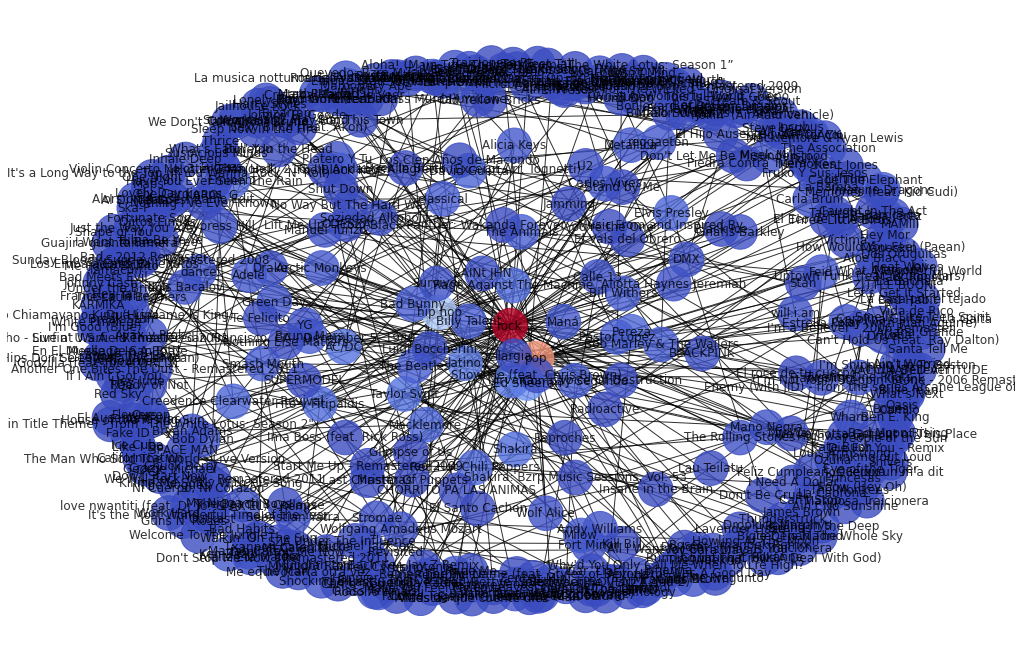

In [261]:
visualizacion_grafo(G,factor_spring_layout)

## Analisis del grafo (centralidad, detencion de comunidades...)

**Miramos los grados**

In [96]:
#vemos los nodos ordenados por grado
nodos = [(node,G.degree(node)) for node  in G.nodes()]
nodos_ordenado = sorted(nodos, key=lambda x: x[1], reverse=True)
nodos_ordenado

[('rock', 64),
 ('pop', 49),
 ('hip hop', 26),
 ('Ed Sheeran', 12),
 ('latino', 9),
 ('Nirvana', 8),
 ('Taylor Swift', 7),
 ('AC/DC', 7),
 ('Shakira', 6),
 ('Rage Against The Machine', 6),
 ('Fito y Fitipaldis', 6),
 ('Queen', 6),
 ('Red Hot Chili Peppers', 5),
 ('Eminem', 5),
 ('David Guetta', 5),
 ('Pereza', 5),
 ('Elvis Presley', 5),
 ('Macklemore', 5),
 ('Creedence Clearwater Revival', 5),
 ('classical', 4),
 ('Limp Bizkit', 4),
 ('The Black Keys', 4),
 ('Bad Bunny', 4),
 ('The Animals', 4),
 ('Måneskin', 4),
 ('Compay Segundo', 4),
 ('Bill Withers', 4),
 ('KAROL G', 4),
 ('Airbourne', 4),
 ('Bruno Mars', 4),
 ('Pastor Lopez', 4),
 ('Billy Talent', 4),
 ('Cristobal Tapia De Veer', 4),
 ('Bob Marley & The Wailers', 4),
 ('Smash Mouth', 4),
 ('The Beatles', 4),
 ('Maroon 5', 4),
 ('Imagine Dragons', 4),
 ('dance', 3),
 ('reggaeton', 3),
 ('Pastor Lopez Y Su Combo', 3),
 ('Taburete', 3),
 ('Ken Zazpi', 3),
 ('Los Embajadores Vallenatos', 3),
 ('Rodrigo y Gabriela', 3),
 ('The Monkees'

**Miramos la conectividad**

In [97]:
print("Es conexo? " + str(nx.is_connected(G)))
print("Componentes: " + str(nx.number_connected_components(G)))

Es conexo? False
Componentes: 7


In [98]:
for c in nx.connected_components(G):
    sg = G.subgraph(c)
    nodos = [(node,sg.degree(node)) for node  in sg.nodes()]
    nodos_ordenado = sorted(nodos, key=lambda x: x[1], reverse=True)
    print("\t" + str(nodos_ordenado))

	[('latino', 9), ('Compay Segundo', 4), ('Pastor Lopez', 4), ('Los Embajadores Vallenatos', 3), ('Rodolfo Aicardi', 3), ('The Latin Brothers', 2), ('Banda Jerez', 2), ('Vallenatos Nativos', 2), ('Fruko Y Sus Tesos', 2), ('Becky G', 2), ('Mi Caleñita', 1), ('El Ausente', 1), ('Ni Cuerpo, Ni Corazón', 1), ('Los Cien Años de Macondo', 1), ('Cariñito Sin MI', 1), ('El Santo Cachon', 1), ('Guajira guantanamera', 1), ('El Preso', 1), ('Traicionera PL', 1), ('La Cabrona', 1), ('Se Le Moja la Canoa', 1), ('Chan chan', 1), ('MAMIII', 1), ('Traicionera', 1), ('Voy para Mayari', 1)]
	[('hip hop', 26), ('Macklemore', 5), ('Eminem', 5), ('JAY-Z', 3), ('Fugees', 3), ('Bizarrap', 3), ('YG', 2), ('Ice Cube', 2), ('Meek Mill', 2), ('EPMD', 2), ('Vladsta', 2), ('Bad Meets Evil', 2), ('Kent Jones', 2), ('Wiz Khalifa', 2), ('Gnarls Barkley', 2), ('Fort Minor', 2), ('Panjabi MC', 2), ('Kid Ink', 2), ('DMX', 2), ('Cypress Hill', 2), ('Marc Rebillet', 2), ('Drake', 2), ('SAINt JHN', 2), ('Macklemore & Ryan L

Tiene sentido que haya 7 componentes conexas porque hay 7 generos diferenciados

**Miramos la densidad**

In [99]:
print(nx.density(G))

0.0044533875366434125


Se observa que la densidad es muy baja. Alta podria ser entorno a un 0.15

**Miramos las medidas de centralidad de los vertices**

In [100]:
#Degree centrality
centrality = nx.degree_centrality(G)
nodos = [(node,centrality[node]) for node  in centrality]
nodos_ordenado = sorted(nodos, key=lambda x: x[1], reverse=True)
nodos_ordenado[:10]

[('rock', 0.14479638009049775),
 ('pop', 0.11085972850678734),
 ('hip hop', 0.05882352941176471),
 ('Ed Sheeran', 0.027149321266968326),
 ('latino', 0.020361990950226245),
 ('Nirvana', 0.01809954751131222),
 ('Taylor Swift', 0.015837104072398193),
 ('AC/DC', 0.015837104072398193),
 ('Shakira', 0.013574660633484163),
 ('Rage Against The Machine', 0.013574660633484163)]

Se observan los mismos resultados que ordando los grados de los nodos como es logico

In [101]:
#Closeness centrality
centrality = nx.closeness_centrality(G)
nodos = [(node,centrality[node]) for node  in centrality]
nodos_ordenado = sorted(nodos, key=lambda x: x[1], reverse=True)
nodos_ordenado[:10]

[('rock', 0.2584626840025202),
 ('pop', 0.18549970040703317),
 ('Nirvana', 0.16634258277962602),
 ('AC/DC', 0.165667764999587),
 ('Rage Against The Machine', 0.16499840029251794),
 ('Fito y Fitipaldis', 0.16499840029251794),
 ('Queen', 0.16499840029251794),
 ('Red Hot Chili Peppers', 0.16433442282655208),
 ('Pereza', 0.16433442282655208),
 ('Elvis Presley', 0.16433442282655208)]

Los resultados son ligeramente diferentes a los de grado y tienen mas sentido en cuanto a mis gustos musicales. En este caso seria el nodo que tiene los caminos mas cortos al resto de vertices

In [102]:
#Betweenness centrality
centrality = nx.betweenness_centrality(G)
nodos = [(node,centrality[node]) for node  in centrality]
nodos_ordenado = sorted(nodos, key=lambda x: x[1], reverse=True)
nodos_ordenado[:10]

[('rock', 0.18163162700977828),
 ('pop', 0.08952298868265256),
 ('hip hop', 0.01826371574270734),
 ('Ed Sheeran', 0.01444680436277075),
 ('Nirvana', 0.013359189829778066),
 ('AC/DC', 0.011481515683196357),
 ('Rage Against The Machine', 0.00959358102215245),
 ('Fito y Fitipaldis', 0.00959358102215245),
 ('Queen', 0.00959358102215245),
 ('Taylor Swift', 0.00803398282389879)]

El betweenness que seria para los caminos mas cortos entre todos los pares de nodos en cuantos aparece ese nodo, los resultados tienen mas sentido en cuanto a mis gustos musicales frente a los anteriores

In [103]:
#Eigenvector centrality
centrality = nx.eigenvector_centrality(G)
nodos = [(node,centrality[node]) for node  in centrality]
nodos_ordenado = sorted(nodos, key=lambda x: x[1], reverse=True)
nodos_ordenado[:15]

[('rock', 0.6961116120914105),
 ('Nirvana', 0.09584958739542487),
 ('AC/DC', 0.09425215016231157),
 ('Rage Against The Machine', 0.09270708611808649),
 ('Fito y Fitipaldis', 0.09270708611808649),
 ('Queen', 0.09270708611808649),
 ('Red Hot Chili Peppers', 0.09121186116199216),
 ('Pereza', 0.09121186116199216),
 ('Elvis Presley', 0.09121186116199216),
 ('Creedence Clearwater Revival', 0.09121186116199216),
 ('Limp Bizkit', 0.08976410208319603),
 ('The Black Keys', 0.08976410208319603),
 ('The Animals', 0.08976410208319603),
 ('Måneskin', 0.08976410208319603),
 ('Airbourne', 0.08976410208319603)]

El eigenvector habla del prestigio de ese nodo. Los resultados tienen mas sentido que el anterior

In [104]:
#pagerank centrality
centrality = nx.pagerank(G)
nodos = [(node,centrality[node]) for node  in centrality]
nodos_ordenado = sorted(nodos, key=lambda x: x[1], reverse=True)
nodos_ordenado[:15]

[('rock', 0.06077495431345102),
 ('pop', 0.04697826633130533),
 ('hip hop', 0.025449146157703842),
 ('Ed Sheeran', 0.012793751635357125),
 ('latino', 0.009165334451801982),
 ('Nirvana', 0.008594979293653287),
 ('Taylor Swift', 0.007567517654613948),
 ('AC/DC', 0.007547520385221001),
 ('Shakira', 0.006516913028044817),
 ('Rage Against The Machine', 0.006497752980756849),
 ('Fito y Fitipaldis', 0.006497752980756849),
 ('Queen', 0.006497752980756849),
 ('David Guetta', 0.005870639870462904),
 ('Eminem', 0.0055027752174091815),
 ('Macklemore', 0.0055027752174091815)]

El pagerank es igual que el eigenvector salvo porque incluye el "damping factor" lo que le añade una aleatoriedad y un nodo podria ser apuntado por otro que no tiene nada que ver. Esto ayuda con los nodos que no tienen aristas yendo a otro lado como puede ser "Rock".

Los resultados estan bien si no fuera por Taylor Swift que aparece muy alto.

Ahora vamos a ver el mayor en todos:

In [105]:
degree = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)
pagerank = nx.pagerank(G)

bestDG = max(degree, key=lambda key: degree[key])
bestCL = max(closeness, key=lambda key: closeness[key])
bestBT = max(betweenness, key=lambda key: betweenness[key])
bestEG = max(eigenvector, key=lambda key: eigenvector[key])
bestPR = max(pagerank, key=lambda key: pagerank[key])

print("Degree: "+ bestDG + " -> {0:.2f}".format(degree[bestDG]))
print("Closeness: "+ bestCL + " -> {0:.2f}".format(closeness[bestCL]))
print("Betweenness: "+ bestBT + " -> {0:.2f}".format(betweenness[bestBT]))
print("Eigenvector: "+ bestEG + " -> {0:.2f}".format(eigenvector[bestEG]))
print("PageRank: "+ bestPR + " -> {0:.2f}".format(pagerank[bestPR]))

Degree: rock -> 0.14
Closeness: rock -> 0.26
Betweenness: rock -> 0.18
Eigenvector: rock -> 0.70
PageRank: rock -> 0.06


**Miramos las medidas de analisis de las aristas**

Otra medida de centralidad es el edge betweenness que seria como el betweenness de los nodos pero en las aristas

In [106]:
centrality = nx.edge_betweenness_centrality(G)
nodos = [(node,centrality[node]) for node  in centrality]
nodos_ordenado = sorted(nodos, key=lambda x: x[1], reverse=True)
nodos_ordenado[:10]

[(('pop', 'Ed Sheeran'), 0.015076146798361643),
 (('rock', 'Nirvana'), 0.01495357649918797),
 (('rock', 'AC/DC'), 0.013155878777974117),
 (('rock', 'Rage Against The Machine'), 0.01133775267356465),
 (('rock', 'Fito y Fitipaldis'), 0.01133775267356465),
 (('rock', 'Queen'), 0.01133775267356465),
 (('rock', 'Red Hot Chili Peppers'), 0.009499198185959571),
 (('rock', 'Pereza'), 0.009499198185959571),
 (('rock', 'Elvis Presley'), 0.009499198185959571),
 (('rock', 'Creedence Clearwater Revival'), 0.009499198185959571)]

Todas estas aristas tienen mucho sentido que sean las que en mas caminos cortos aparezcan en funcion de mis gustos musicales

Las medidas de cliques, kcores, diadas, triadas... no tienen mucho sentido aplicar a este grafo forma de arbol porque basicamente son canciones que estan ligadas cada una a solo un artista que esta ligado solo a un genero

**Miramos las medidas de deteccion de comunidades**

Para ello probamos con louvain que de los clasicos es de los que mejor suele funcionar:

In [107]:
c = community.louvain_communities(G)
print(community.modularity(G, c))

n_comunidades=0
for ci in sorted(c):
    print(ci)
    n_comunidades+=1
print('********************************************************************')
print("distingue "+str(n_comunidades)+" comunidades diferentes")

0.7970314998737481
{'The Latin Brothers', 'Traicionera PL', 'Banda Jerez', 'Becky G', 'La Cabrona', 'Compay Segundo', 'Mi Caleñita', 'Se Le Moja la Canoa', 'El Ausente', 'Chan chan', 'Pastor Lopez', 'MAMIII', 'Ni Cuerpo, Ni Corazón', 'Vallenatos Nativos', 'Traicionera', 'Rodolfo Aicardi', 'Fruko Y Sus Tesos', 'Voy para Mayari', 'Los Cien Años de Macondo', 'Cariñito Sin MI', 'El Santo Cachon', 'Los Embajadores Vallenatos', 'latino', 'Guajira guantanamera', 'El Preso'}
{'Michael Jackson', 'OneRepublic', 'Luis Bacalov', 'CKay', 'SPACE MAN', 'The Association', 'Die For You - Remix', 'Vida de Rico', 'Running Up That Hill (A Deal With God)', 'El Hijo Ausente', 'Pastor Lopez Y Su Combo', 'El Eco de Tu Adios', 'Kate Bush', 'Rihanna', 'Kill Bill', 'Alors on danse - Radio Edit', 'Taburete', 'Feliz Cumpleaños Ferxxo', 'Mexico D.F.', 'Bad - 2012 Remaster', 'Flowers', 'Carla Bruni', 'Mariah Carey', 'Sam Cooke', 'En El Muelle De San Blas', 'Sebastian Yatra', 'Make You Feel My Love', "You're the One"

La modularidad es muy alta con lo que se observa un alto frado de comunidades. Sin embargo, se esta descubriendo nada porque realmente la propia estructura de canciones agrupada por artistas son las comunidades que muestra en general

In [139]:
#creamos una lista de colores automaticos
color_names = plt.get_cmap('tab10').colors
community_to_color = {i: color_names[i % len(color_names)] for i in range(n_comunidades)}

C:\Python310\lib\site-packages\netgraph\_node_layout.py:1549: UserWarning: Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.
  warnings.warn("Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.")
C:\Python310\lib\site-packages\netgraph\_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]


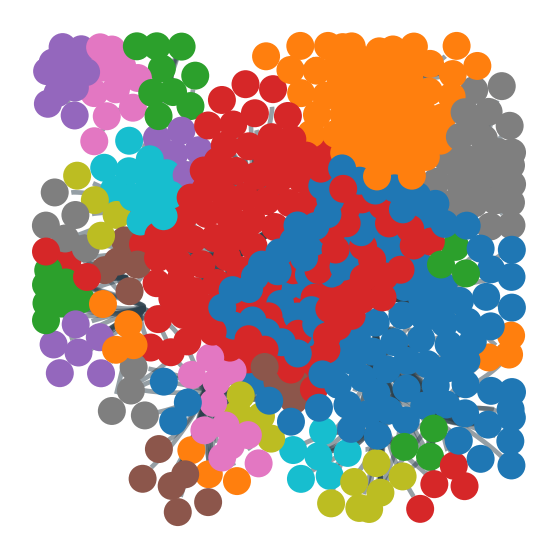

In [185]:
node_color = {}
node_to_community = {}
id = 0
for ci in sorted(c):
    for node in ci:
        node_color[node] = community_to_color[id]
        node_to_community[node] = id
    id += 1

plt.figure(figsize=(15, 10))
Graph(G,
      node_color=node_color, node_edge_width=0, edge_alpha=0.5,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=50),
)

plt.show()

No se percibe nada relevante

## De los analisis del grafo que incluir

De las diferentes medidas analizadas anteriormente la mas relevante para este tipo de grafo resulta ser las de centralidad y el page rank daba los resultados mas coherentes con respecto a los gustos musicales

In [108]:
centrality = nx.pagerank(G)
nx.set_node_attributes(G, centrality, "centrality")

In [109]:
partition = community.louvain_communities(G)
len(partition)

34

In [110]:
# Add the communities as a node attribute with the name 'communities'
for node, community in partition.items():

AttributeError: 'list' object has no attribute 'items'

In [111]:
communities = nx.algorithms.community.louvain_communities(G)

# Add the communities as a node attribute with the name 'communities'
for community_id, community in enumerate(communities):
    for node in community:
        G.nodes[node]['communities'] = community_id

# Print the graph with node attributes
print(G.nodes(data=True))

[('latino', {'id': 'latino', 'image': 'https://img.freepik.com/vector-premium/ilustracion-banda-musica-latina-dibujada-mano_52683-91269.jpg', 'type': 'genre', 'centrality': 0.009165334451801982, 'communities': 28}), ('hip hop', {'id': 'hip hop', 'image': 'https://img.freepik.com/premium-vector/hip-hop-style-t-shirt-design_9645-1054.jpg', 'type': 'genre', 'centrality': 0.025449146157703842, 'communities': 4}), ('dance', {'id': 'dance', 'image': 'https://www.shutterstock.com/shutterstock/photos/1143150974/display_1500/stock-vector-electronic-dance-music-vector-illustration-1143150974.jpg', 'type': 'genre', 'centrality': 0.003482323968367061, 'communities': 0}), ('pop', {'id': 'pop', 'image': 'https://c8.alamy.com/compes/2amt118/letras-de-vector-3d-vintage-de-musica-pop-fuente-retro-negrita-tipo-de-letra-texto-estilizado-del-arte-pop-letras-de-estilo-de-la-vieja-escuela-90s-poster-de-los-80s-banner-la-mitad-azul-2amt118.jpg', 'type': 'genre', 'centrality': 0.04697826633130533, 'communitie

Meter nodo de usuario

In [112]:
#ahora incluimos los nodos de los artistas con sus aristas con los generos
for index, row in df_artistas_filtrados.iterrows():
    artist_name = row['name']

    G.add_node(artist_name,
               image=row['image3'],
               id=artist_name,
               n_times_listen=row['n_times_listen'],
               type=row['type'],
               followers=row['followers'],
               popularity=row['popularity'],
               uri=row['uri'])

    # ahora creamos las aristas con los generos
    if row['genres'] in G.nodes:
            G.add_edge(artist_name, row['genres'])

In [113]:
image_usuario="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRukldoxNb0k33qjApYyMG_ucLVdMo62gXPg-wjfcex3g&s"
type_usuario="user"
id_usuario="Dani"
usuario_name="usuario"

G.add_node(usuario_name,
            image=image_usuario,
            id=id_usuario,
            type=type_usuario
        )


In [114]:
for node, data in G.nodes(data=True):
    if node != usuario_name and data['type'] == 'genre':
        G.add_edge(usuario_name,node)

In [186]:
#edges_to_remove = list(G.edges(usuario_name))

# Remove edges one by one
#for edge in edges_to_remove:
    #G.remove_edge(*edge)

In [116]:
#añadimos el edge_betweenness
edge_betweenness = nx.edge_betweenness_centrality(G)

nx.set_edge_attributes(G, edge_betweenness, 'edge_betweenness')

## Generacion del JSON con el grafo de networkx creado

In [117]:
#creamos el nombre del JSON
filename = 'grafo_musica_grupo3_com_usu_buena_final.json'

#creamos el json para cargar en d3js
json_data = json_graph.node_link_data(G)

with open(filename, 'w') as outfile:
    json.dump(json_data, outfile, indent=1)